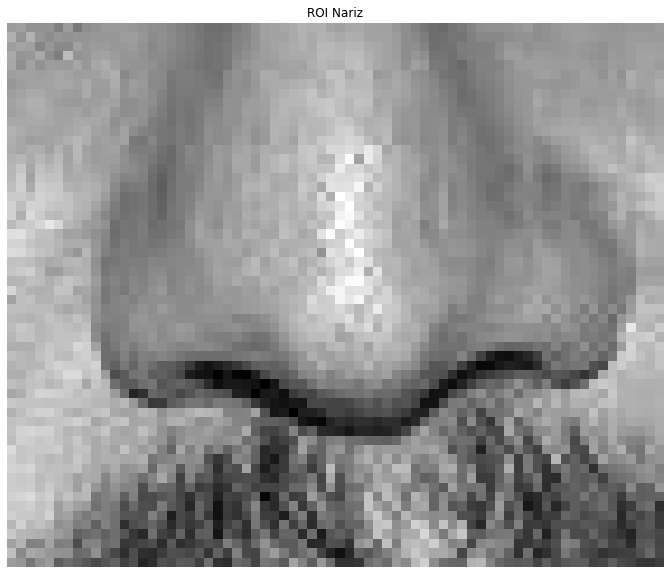

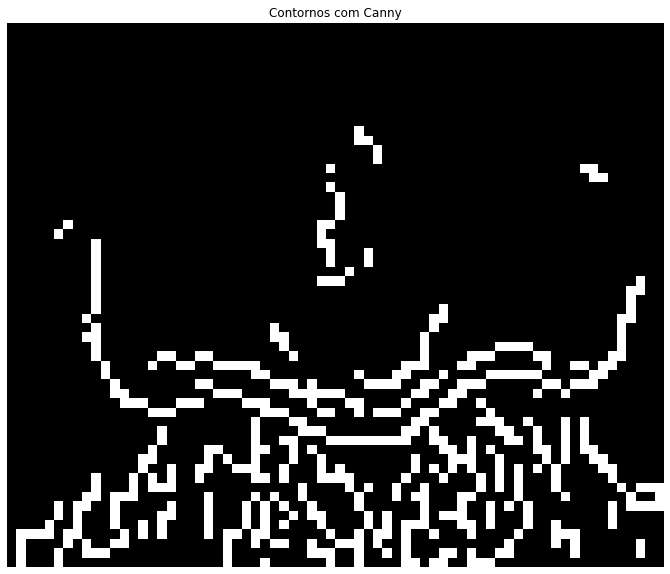

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
446
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 1.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.

In [89]:
# pip install opencv-python==4.9.0.80 
# pip install numpy==1.26.4
# pip install matplotlib==3.9.0
# pip install networkx==3.3
# pip install scipy==1.13.0

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.csgraph import connected_components

# Função que recebe uma imagem colorida como entrada e retorna a mesma imagem convertida para escala de cinza
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Converter a imagem de um espaço de cores RGB para escala de cinza
    return gray

# Função que usará um modelo para detectar o rosto de uma pessoa
def detect_faces(image, face_classifier):
    faces = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return faces

# Função que usará um modelo para detectar os olhos de uma pessoa
def detect_eyes(image, eyes_classifier):
    eyes = eyes_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return eyes

# Função que usará um modelo para detectar o nariz de uma pessoa
def detect_noses(image, nose_classifier):
    noses = nose_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return noses

# Função que usará um modelo para detectar a boca de uma pessoa
def detect_mouths(image, mouth_classifier):
    mouths = mouth_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return mouths

# Função que irá nos retornar os contornos de uma imagem
def apply_canny(image):
    edges = cv2.Canny(image, 150, 200)
    return edges

# Função que plotará imagens
def plots(figura, title=''):
    plt.figure(figsize=(20,10))
    plt.imshow(figura, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Função que aleatoriza 
def retirando_pixels(mEdges, thresh):
    lCoord = [] # Lista para armazenar as coordenddas dos pixels de interesse

    for i in range(mEdges.shape[0]):
        for j in range(mEdges.shape[1]):
            if mEdges[i][j] == 255: # Verificando se o ponto encontrado corresponde ao pixel 255
                lCoord.append((i,j)) # Adicionando a coordenada desse pixel encontrado no lCoord
    lCoord2 = lCoord.copy() # Copiando a lista de coordenadas dos pontos
    random.shuffle(lCoord) # Aleatorizando a ordem das coordenadas dos pontos

    times = thresh # Definando um limiar para zerarmos os pixels

    #for i,t in zip(lCoord, range(times)): # Zipamos a lista de coordenadas com o limiar para definirmos um 'critério de parada' no laço
    #        mEdges[i[0]][i[1]] = 0 # Zerando os pixels 255

    return mEdges, lCoord2

# Função que fará o processamento de imagem e nos retornará os contornos das características
def process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier):
    image = cv2.imread(image_path)
    processed_image = preprocess_image(image)
    faces = detect_faces(processed_image, face_classifier)

    for (x, y, w, h) in faces:
        face_roi = processed_image[y:y+h, x:x+w]
        noses = detect_noses(face_roi, nose_classifier)

        for (nx, ny, nw, nh) in noses:
            nose_roi = face_roi[ny:ny+nh, nx:nx+nw]
            plots(nose_roi, title="ROI Nariz")
            nose_edges = apply_canny(nose_roi)
            plots(nose_edges, title="Contornos com Canny")
            newNoseEdges, lCoord2 = retirando_pixels(nose_edges, 100)

    return nose_edges, lCoord2

# Função para processar a matriz e retornar as ligações entre os pontos
def processar_matriz(matriz, limViz1, limViz2):
    def coord_pts(matriz):
        dAuxiliar = {}  # Um dicionário auxiliar para armazenar as coordenadas dos pontos
        pto = 0  # Um contador para contabilizarmos os pontos
        for i in range(matriz.shape[0]):
            for j in range(matriz.shape[1]):
                if matriz[i][j] == 255:  # Verificando se o ponto encontrado corresponde ao pixel 255
                    dAuxiliar[(i, j)] = pto  # Adicionando esse pixel encontrado no dAuxiliar
                    pto += 1
        return dAuxiliar

    def linha_coluna(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return x1 == x2 or y1 == y2

    def diagonal(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return abs(x1 - x2) == abs(y1 - y2)

    def distancia_absoluta(ponto1, ponto2):
        distancia_x = abs(ponto1[0] - ponto2[0])
        distancia_y = abs(ponto1[1] - ponto2[1])
        return distancia_x + distancia_y

    def vizinhanca(ponto1, ponto2, limite):
        distancia = distancia_absoluta(ponto1, ponto2)
        return distancia <= limite

    def verificar_vizinhanca(pontos, limViz1, limViz2):
        ligacoes = {}  # Dicionário para armazenar as ligações entre os pontos
        for ponto1, id1 in pontos.items():
            ligacoes[id1] = []  # Inicializa a lista de ligações para o ponto atual
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if linha_coluna(ponto1, ponto2):  # Verificando se os pontos estão na mesma linha/coluna
                        if vizinhanca(ponto1, ponto2, limViz1):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações

        for ponto1, id1 in pontos.items():
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if diagonal(ponto1, ponto2):  # Evitar calcular a distância do ponto com ele mesmo
                        if vizinhanca(ponto1, ponto2, limViz2):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações
        return ligacoes

    pontos = coord_pts(matriz)
    resultado = verificar_vizinhanca(pontos, limViz1, limViz2)
    return resultado

# Função para criar a matriz de adjacências
def matriz_adjacencias(graph_dict):
    n = max(graph_dict.keys()) + 1 # Encontra o maior número de nó no grafo e adiciona 1 a ele para ajustar a indexação que começa em 0 no python
    M = np.zeros((n,n)) # Uma matriz de adjacência quadrada n = qtde pixels 255
    print(M)
    
    for node, neighbors in graph_dict.items(): #Itera sobre o dicionário onde cada chave representa um nó e o valor é uma lista de vizinhos desse nó.
        for neighbor in neighbors: # Itera sobre a lista de vizinhos do nó atual.
            M[node][neighbor] = 1 # Define a entrada correspondente na matriz de adjacência como 1 para indicar uma aresta entre o nó node e o vizinho neighbor.
    
    return M

def main():
    directory = './image'
    face_classifier = cv2.CascadeClassifier("./models/haarcascade_frontalface_default.xml")
    eyes_classifier = cv2.CascadeClassifier("./models/haarcascade_eye.xml")
    nose_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_nose.xml")
    mouth_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_mouth.xml")
    
    all_mAdjNose = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".ppm"):
            image_path = os.path.join(directory, filename)
            mNoseEdges, lCoord2 = process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier)
            dLigacoes = processar_matriz(mNoseEdges, limViz1 = 1, limViz2 = 2)
            mAdjNose = matriz_adjacencias(dLigacoes)
            print(len(mAdjNose[28:]))

            for i in range(346):
                print(i, mAdjNose[31][i])

            all_mAdjNose.append(mAdjNose)
    return all_mAdjNose, lCoord2, image_path

if __name__ == "__main__": 
    all_mAdjNose, lCoord2, image_path = main()


In [90]:

n_components, labels = connected_components(all_mAdjNose[0])   
print(n_components)
print(labels)


33
[ 0  0  0  0  0  1  2  2  2  2  3  3  3  3  4  3  3  4  3  5  3  3  5  3
  6  5  3  6  5  7  5  7  7  7  8  5  8  8  5  8  5  9  8  5  9  9  8  8
  5 10  9  8  5  5 10 10  9  8  5 10  9  8  8  8  8  8  5 11 11 11 11 10
  9  8  8  8  8  8  8  8  5 11 11 11 11 11 11 11 11  9  9  9  8  8  8  8
  8  8  8  5 11 11  9  9  9 12  8  8  8  8  8  8  8  8  5  8  8 11 11 11
 11  9  9  9  9 12 12  8  8  8  8  8  8  8  8  5  5  8  8  8 11 11 11 11
 11 11 12 12  8  8  8  8  5  5  5  5  5  5  8  8  8 11 11 11 12  8  8 13
  5  5  5  8  8  8 11 11 11 12 12 12  8  8 13  8  8  8  8  8 13 13 13 14
 14 15 16  8  8  8  8  8  8  8 13 13 14 14 15 16  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8 13 13 14 14 15 16  8  8  8  8  8 17  8  8  8 18 14
 14 14 15 15 16 16  8  8  8  8 17 19  8  8  8 18 14 14 15 15 16 16  8  8
  8  8  8  8 17 17 19  8  8  8 18 20 14 14 15 15 16 16 16 16  8  8  8  8
 17 17 17 17 19  8  8 18 20 14 15 16 16 16 16 16 17 17 17 19 21  8 18 20
 14 15 15 15 15 16 16 16 16 16 22 23 23 17 17 19

In [129]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

nodes = dicLabels[3]

componente_3 = all_mAdjNose[0][np.ix_(nodes,nodes)]
minimum_spanning_tree(componente_3).toarray().astype(int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [91]:

dicLabels = {} # Dicionário para armazenar os labels e seus respectivos índices

for i in range(len(labels)): # Iterar sobre os labels e seus respectivos índices
    if labels[i] not in dicLabels: # Verificar se o label atual já está no dicionário
        dicLabels[labels[i]] = [i] # Se não estiver, adiciona o índice atual em uma lista
    else:
        dicLabels[labels[i]].append(i) # Se já estiver, adiciona o índice atual à lista de índices

print('Dicionário de labels:', dicLabels)


Dicionário de labels: {0: [0, 1, 2, 3, 4], 1: [5], 2: [6, 7, 8, 9], 3: [10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 26], 4: [14, 17], 5: [19, 22, 25, 28, 30, 35, 38, 40, 43, 48, 52, 53, 58, 66, 80, 99, 114, 135, 136, 152, 153, 154, 155, 156, 157, 168, 169, 170], 6: [24, 27], 7: [29, 31, 32, 33], 8: [34, 36, 37, 39, 42, 46, 47, 51, 57, 61, 62, 63, 64, 65, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 148, 149, 150, 151, 158, 159, 160, 165, 166, 171, 172, 173, 180, 181, 183, 184, 185, 186, 187, 195, 196, 197, 198, 199, 200, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 229, 230, 231, 232, 233, 235, 236, 237, 246, 247, 248, 249, 252, 253, 254, 262, 263, 264, 265, 266, 267, 271, 272, 273, 284, 285, 286, 287, 293, 294, 309, 330, 331, 348, 371, 372, 373, 392, 393, 418], 9: [41, 44, 45, 50, 56, 60, 72, 89, 90, 91, 102, 103, 104, 121, 122, 123, 124], 

In [92]:

dicLabelsAux = {} # Dicionário auxiliar para armazenar o número de nó em cada conexo

for i in dicLabels.keys(): # Iterar sobre as chaves do dicionário de labels
    dicLabelsAux[i] = len(dicLabels[i]) # Adicionar o número de conectividades em cada conexo ao dicionário auxiliar
print('Dicionário com a quantidade de nós:',dicLabelsAux) 


Dicionário com a quantidade de nós: {0: 5, 1: 1, 2: 4, 3: 11, 4: 2, 5: 28, 6: 2, 7: 4, 8: 130, 9: 17, 10: 5, 11: 30, 12: 9, 13: 9, 14: 16, 15: 20, 16: 40, 17: 38, 18: 5, 19: 5, 20: 16, 21: 14, 22: 5, 23: 21, 24: 10, 25: 5, 26: 3, 27: 3, 28: 2, 29: 7, 30: 2, 31: 4, 32: 1}


In [93]:
largeKey = max(dicLabelsAux, key=dicLabelsAux.get) # Encontrar a chave com o maior valor 
print('Maior nº de nós em um conexo:', dicLabelsAux[largeKey])
tinyKey = min(dicLabelsAux, key=dicLabelsAux.get) # Encontrar a chave com o menor valor
print('Menor nº de nós em um conexo:', dicLabelsAux[tinyKey])


Maior nº de nós em um conexo: 130
Menor nº de nós em um conexo: 1


In [94]:
listDelKeys = [] # Lista para armazenar as chaves que serão deletadas

for key in dicLabelsAux.keys(): # Iterar sobre as chaves do dicionário auxiliar
    if dicLabelsAux[key] < round(0.2 * dicLabelsAux[largeKey]): # Verificar se o número de nós é menor que 20% do maior número de nós
        listDelKeys.append(key) # Adicionar a chave à lista de chaves que serão deletadas

for key in listDelKeys: # Iterar sobre a lista de chaves que serão deletadas
    del dicLabelsAux[key] # Deletar a chave do dicionário auxiliar

listMainKeys = dicLabelsAux.keys() # Lista para armazenar as chaves que serão mantidas
print('Lista das chaves que serão filtradas:', listMainKeys)


Lista das chaves que serão filtradas: dict_keys([5, 8, 11, 16, 17])


In [95]:
dicNewLabels = {} # Dicionário para armazenar os novos labels

for key in listMainKeys: # Iterar sobre as chaves que serão mantidas
    dicNewLabels[key] = dicLabels[key] # Adicionar os índices dos labels que serão mantidos ao dicionário de novos labels

print('Dicionário com os labels filtrados:', dicNewLabels)


Dicionário com os labels filtrados: {5: [19, 22, 25, 28, 30, 35, 38, 40, 43, 48, 52, 53, 58, 66, 80, 99, 114, 135, 136, 152, 153, 154, 155, 156, 157, 168, 169, 170], 8: [34, 36, 37, 39, 42, 46, 47, 51, 57, 61, 62, 63, 64, 65, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 148, 149, 150, 151, 158, 159, 160, 165, 166, 171, 172, 173, 180, 181, 183, 184, 185, 186, 187, 195, 196, 197, 198, 199, 200, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 229, 230, 231, 232, 233, 235, 236, 237, 246, 247, 248, 249, 252, 253, 254, 262, 263, 264, 265, 266, 267, 271, 272, 273, 284, 285, 286, 287, 293, 294, 309, 330, 331, 348, 371, 372, 373, 392, 393, 418], 11: [67, 68, 69, 70, 81, 82, 83, 84, 85, 86, 87, 88, 100, 101, 117, 118, 119, 120, 140, 141, 142, 143, 144, 145, 161, 162, 163, 174, 175, 176], 16: [194, 207, 228, 244, 245, 260, 261, 280, 281, 282, 283, 299

In [96]:

# Função para destacar as componentes conectadas na imagem original
# Função para plotar imagens
def plots(figura, title=''):
    plt.figure(figsize=(8, 6))
    plt.imshow(figura, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()


# Função para destacar os pontos das componentes conectadas
def highlight_components(lCoord2, dicNewLabels):
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'orange']
    plt.figure(figsize=(8, 6))
    
    for color,label in enumerate(dicNewLabels.keys()): # Iterar sobre as chaves do dicionário de novos labels
        for idx in dicNewLabels[label]: # Iterar sobre os índices dos labels que serão mantidos
            i, j = lCoord2[idx]
            print(i, j, idx)
            plt.scatter(j, i, color=colors[color%len(colors)])  # Plotar os pontos filtrados
    
    plt.title("Pontos das Componentes Conectadas")
    plt.xlabel("Coluna")
    plt.ylabel("Linha")
    plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
    plt.grid(True)
    plt.show()



23 9 19
24 9 22
25 9 25
26 9 28
27 9 30
28 9 35
29 9 38
30 9 40
31 8 43
32 9 48
33 8 52
33 9 53
34 9 58
35 9 66
36 10 80
37 10 99
38 11 114
39 11 135
39 12 136
40 12 152
40 13 153
40 14 154
40 18 155
40 19 156
40 20 157
41 15 168
41 16 169
41 17 170
27 67 34
28 66 36
28 67 37
29 66 39
30 66 42
31 65 46
31 66 47
32 65 51
33 65 57
34 52 61
34 53 62
34 54 63
34 55 64
34 65 65
35 49 73
35 50 74
35 51 75
35 56 76
35 57 77
35 64 78
35 65 79
36 48 92
36 49 93
36 57 94
36 60 95
36 61 96
36 63 97
36 64 98
37 51 106
37 52 107
37 53 108
37 54 109
37 55 110
37 56 111
37 62 112
37 63 113
38 20 115
38 21 116
38 48 127
38 49 128
38 50 129
38 57 130
38 58 131
38 60 132
38 61 133
38 62 134
39 22 137
39 23 138
39 24 139
39 47 148
39 48 149
39 56 150
39 59 151
40 25 158
40 26 159
40 27 160
40 46 165
40 47 166
41 27 171
41 28 172
41 29 173
41 44 180
41 45 181
42 26 183
42 30 184
42 31 185
42 43 186
42 44 187
43 26 195
43 31 196
43 32 197
43 33 198
43 42 199
43 43 200
43 45 201
44 26 208
44 29 209
44 30 21

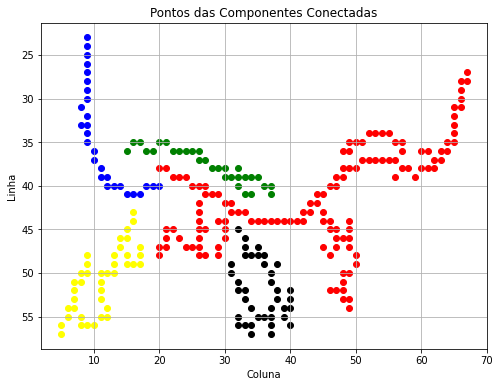

In [97]:
# - lCoord2: lista de coordenadas dos pontos de interesse
# - dicNewLabels: dicionário com os índices dos pontos filtrados por componente conectada

highlight_components(lCoord2, dicNewLabels)

23 9 19
24 9 22
25 9 25
26 9 28
27 9 30
28 9 35
29 9 38
30 9 40
31 8 43
32 9 48
33 8 52
33 9 53
34 9 58
35 9 66
36 10 80
37 10 99
38 11 114
39 11 135
39 12 136
40 12 152
40 13 153
40 14 154
40 18 155
40 19 156
40 20 157
41 15 168
41 16 169
41 17 170
27 67 34
28 66 36
28 67 37
29 66 39
30 66 42
31 65 46
31 66 47
32 65 51
33 65 57
34 52 61
34 53 62
34 54 63
34 55 64
34 65 65
35 49 73
35 50 74
35 51 75
35 56 76
35 57 77
35 64 78
35 65 79
36 48 92
36 49 93
36 57 94
36 60 95
36 61 96
36 63 97
36 64 98
37 51 106
37 52 107
37 53 108
37 54 109
37 55 110
37 56 111
37 62 112
37 63 113
38 20 115
38 21 116
38 48 127
38 49 128
38 50 129
38 57 130
38 58 131
38 60 132
38 61 133
38 62 134
39 22 137
39 23 138
39 24 139
39 47 148
39 48 149
39 56 150
39 59 151
40 25 158
40 26 159
40 27 160
40 46 165
40 47 166
41 27 171
41 28 172
41 29 173
41 44 180
41 45 181
42 26 183
42 30 184
42 31 185
42 43 186
42 44 187
43 26 195
43 31 196
43 32 197
43 33 198
43 42 199
43 43 200
43 45 201
44 26 208
44 29 209
44 30 21

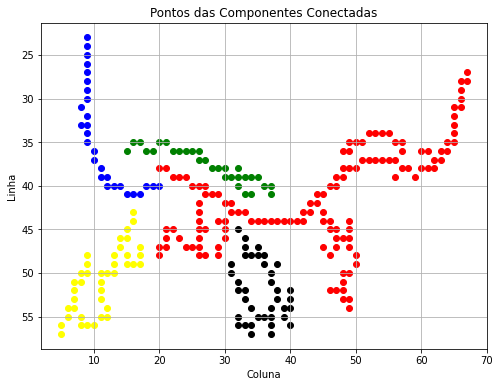

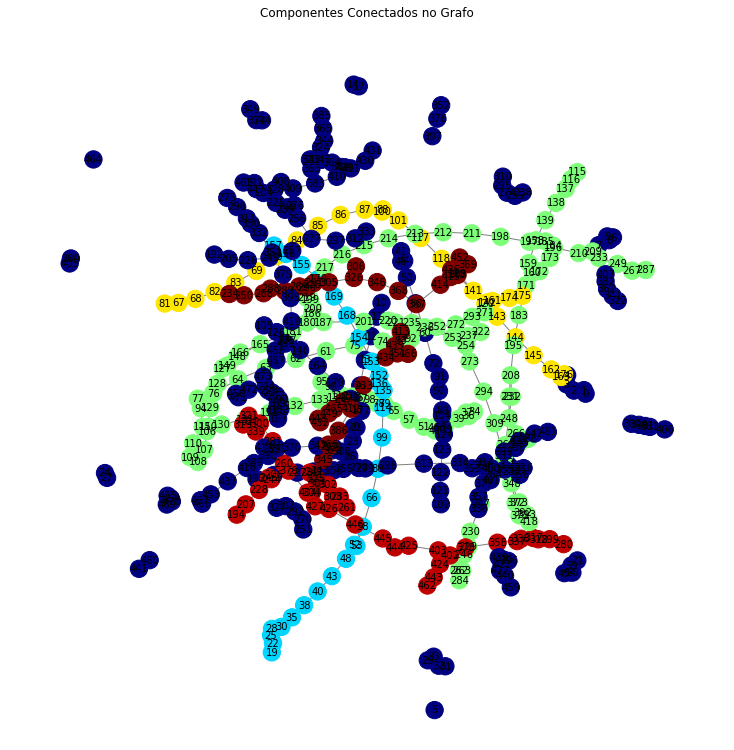

In [98]:

# - lCoord2: lista de coordenadas dos pontos de interesse
# - dicNewLabels: dicionário com os índices dos pontos filtrados por componente conectada

highlight_components(lCoord2, dicNewLabels)

# Criar o grafo usando NetworkX
G = nx.Graph()

# Adicionar nós e arestas ao grafo
for i in range(all_mAdjNose[0].shape[0]):
    G.add_node(i)
    
rows, cols = all_mAdjNose[0].nonzero()
edges = zip(rows.tolist(), cols.tolist())
G.add_edges_from(edges)

# Definir cores para os componentes conectados
colors = []
for node in G.nodes():
    if labels[node] in dicNewLabels:
        colors.append(labels[node])
    else:
        colors.append(-1)  # Nó não filtrado

# Plotar o grafo
pos = nx.spring_layout(G)  # Layout do grafo
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=300, cmap=plt.cm.jet, edge_color='gray', font_size=10)
plt.title('Componentes Conectados no Grafo')
plt.show()

